In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joypy
import pacmap
import fitsne
import umap
import flowkit as fk

%matplotlib inline

In [2]:
def make_plots(data, sample_ids, titles, marker, k=10000, seed=123):
    """Reduce scatter and fluroescent channel data to 2D for visualization."""

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    umap_reducer = umap.UMAP()
    pacmap_reducer = pacmap.PaCMAP()

    X_fitsne = fitsne.FItSNE(data_scaled)
    X_umap = umap_reducer.fit_transform(data_scaled)
    X_pacmap = pacmap_reducer.fit_transform(data_scaled)
    
    min_max_scaler = MinMaxScaler()
    X_reduceds = [
        min_max_scaler.fit_transform(tmp_x) for tmp_x in [X_fitsne, X_umap, X_pacmap]
    ]
    
    n = len(X_reduceds)
    fig, axes = plt.subplots(n, 3, figsize=(n*3, 9))

    for i, (X_reduced, title) in enumerate(zip(X_reduceds, titles)):
        for j in range(3):
            z = X[marker].iloc[(j*k):(j+1)*k]
            ax = axes[j, i]
            ax.scatter(
                X_reduced[(j*k):(j+1)*k, 0], 
                X_reduced[(j*k):(j+1)*k, 1], 
                s=1, 
                c=z, 
                cmap='jet'
            )
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim([-0.1,1.1])
            ax.set_ylim([-0.1,1.1])
            
            if j==0:
                ax.set_title(title, fontsize=14)
            if i==0:
                ax.set_ylabel('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
    
    plt.tight_layout()

In [3]:
base_dir = "data/8_color_data_set"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

In [4]:
session = fk.Session(sample_path)
session.import_flowjo_workspace(wsp_path)

In [5]:
sample_groups = session.get_sample_groups()
sample_groups

['default', 'All Samples', 'DEN']

In [6]:
sample_group = sample_groups[-1]

In [7]:
print(session.get_gate_hierarchy(sample_group, output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


In [8]:
sample_ids = sorted(session.get_group_sample_ids(sample_group))
sample_ids

['101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

In [9]:
session.analyze_samples(sample_group)

#### Processing gates for 3 samples (multiprocessing is enabled - 3 cpus) ####


## Compare marker distributions between CD4+ and CD8+

In [11]:
k = 10_000

dfs_cd4 = session.get_wsp_gated_events(sample_group, gate_name='CD4+')
dfs_cd8 = session.get_wsp_gated_events(sample_group, gate_name='CD8+')

X_cd4 = pd.melt(pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs_cd4]))
X_cd8 = pd.melt(pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs_cd8]))

X = pd.concat([X_cd4, X_cd8], axis=1)
X = X.iloc[:, [0,1,3]]
X.columns = ['marker', 'CD4+', 'CD8+']

In [12]:
X

,marker,CD4+,CD8+
0,FSC-A,0.415104,0.651214
1,FSC-A,0.417530,0.576456
2,FSC-A,0.361775,0.713988
3,FSC-A,0.450074,0.644566
4,FSC-A,0.807138,0.444960
...,...,...,...
419995,CD4 PE-Cy7 FLR-A,0.557230,0.258391
419996,CD4 PE-Cy7 FLR-A,0.606911,0.352749
419997,CD4 PE-Cy7 FLR-A,0.606105,0.386881
419998,CD4 PE-Cy7 FLR-A,0.597891,0.324149


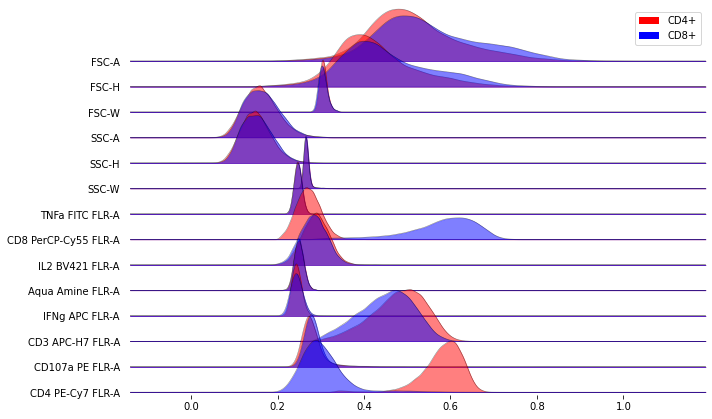

In [13]:
fig, ax = joypy.joyplot(
    X.groupby('marker', sort=False), 
    column=['CD4+', 'CD8+'],
    color=['red', 'blue'],
    legend=True,
    alpha=0.5,
    linewidth=0.5,
    ylim='own',
    figsize=(10, 6)
)

## Visualize dimension reduction schemes for events in Singlet gate

Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 30000, K: 90, N*K = 2700000
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (16 threads):


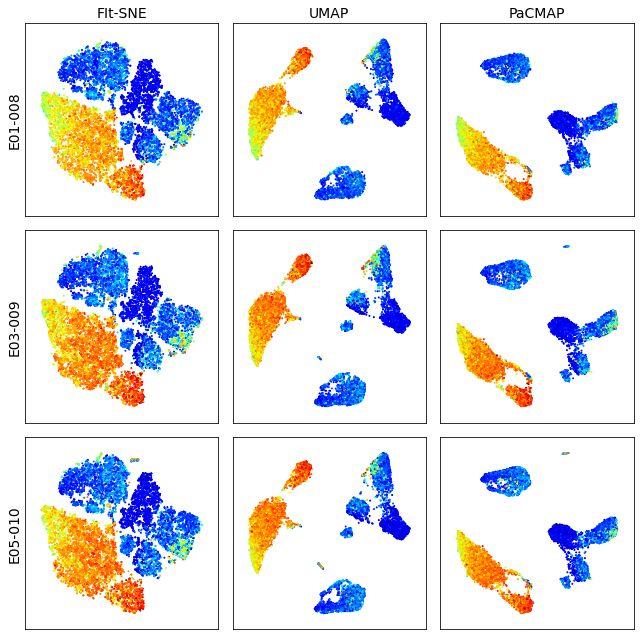

In [14]:
k = 10_000

dfs = session.get_wsp_gated_events(sample_group, gate_name='Singlets')
X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

marker = 'CD4 PE-Cy7 FLR-A'
titles = ['FIt-SNE', 'UMAP', 'PaCMAP']
make_plots(X, sample_ids, titles, marker, k)

## Visualize dimension reduction schemes for events in CD3+ gate


Symmetrizing...
Using the given initialization.
Exaggerating Ps by 12.000000
Input similarities computed (sparsity = 0.004265)!
Learning embedding...
Using FIt-SNE approximation.
Iteration 50 (50 iterations in 0.88 seconds), cost 5.444592
Iteration 100 (50 iterations in 0.88 seconds), cost 5.013565
Iteration 150 (50 iterations in 0.88 seconds), cost 4.916514
Iteration 200 (50 iterations in 0.88 seconds), cost 4.857249
Iteration 250 (50 iterations in 0.88 seconds), cost 4.845203
Unexaggerating Ps by 12.000000
Iteration 300 (50 iterations in 0.89 seconds), cost 3.638935
Iteration 350 (50 iterations in 0.89 seconds), cost 3.190875
Iteration 400 (50 iterations in 1.20 seconds), cost 2.956416
Iteration 450 (50 iterations in 1.79 seconds), cost 2.807386
Iteration 500 (50 iterations in 2.62 seconds), cost 2.701692
Iteration 550 (50 iterations in 3.10 seconds), cost 2.614491
Iteration 600 (50 iterations in 3.54 seconds), cost 2.547919
Iteration 650 (50 iterations in 4.47 seconds), cost 2.4998

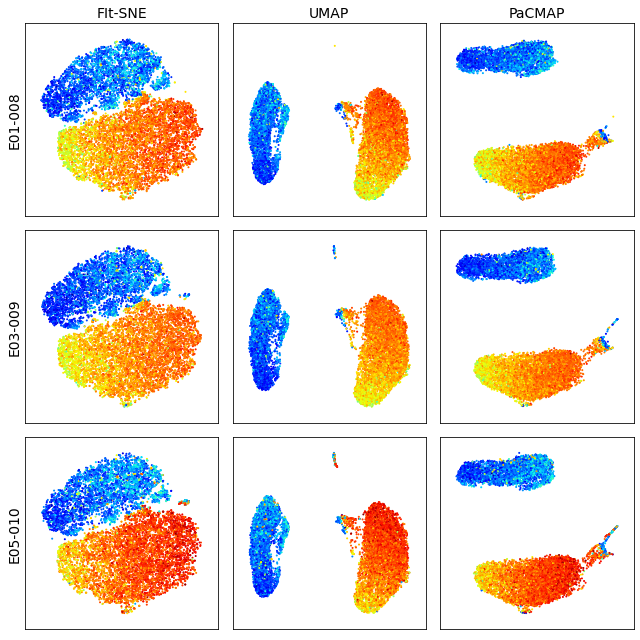

In [15]:
k = 10_000

dfs = session.get_wsp_gated_events(sample_group, gate_name='CD3+')
X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

marker = 'CD4 PE-Cy7 FLR-A'
titles = ['FIt-SNE', 'UMAP', 'PaCMAP']
make_plots(X, sample_ids, titles, marker, k)